This notebook validates the Nufft code from three aspects:
1. The non-uniform data we get from Nufft operator, is very similar to the kspace date we generate from system matrix;
2. The derivative of Nufft operator is computed correctly;
3. Batch works.


## 0 Loading libraries and data

For first two step (validation of Nufft approximation and derivative) I use 2D image with size (48, 48) due to computation ability limit.

In [1]:
import os
from tfNufft import tfNUFFT
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import cv2

In [2]:
folder_path = r'./data'
traj = np.load(os.path.join(folder_path, '2dspiral.npy'))
image = np.load(os.path.join(folder_path, '2dobj.npy'))
image = cv2.resize(image,(48,48))

In [3]:
om = traj.copy()
om[:,0] = traj[:,1]
om[:,1] = traj[:,0]
om = om / om.max() * 3  # normalized between (-pi,pi)

In [4]:
print(om.shape)

(4783, 2)


Text(0.5, 1.0, 'spiral trajectory')

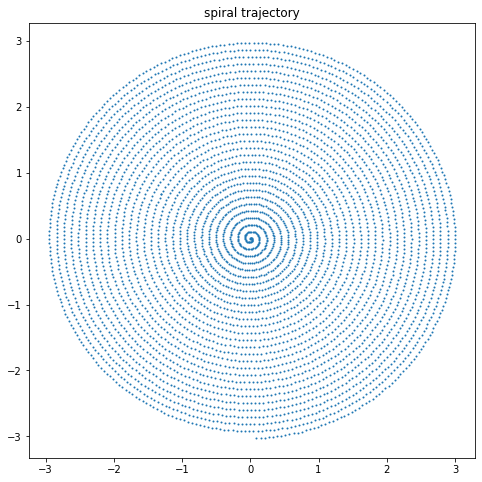

In [5]:
plt.figure(figsize=(8,8))
plt.scatter(om[:,0], om[:,1],s=1)
plt.title('spiral trajectory')

In [6]:
Nd = image.shape # image size
Kd = Nd # fft size
Jd = (3,3) #kernel size

Here input batch images are with shape (batch, Nd).

In [7]:
batch = 1
batch_image = np.expand_dims(image, axis=0)
batch_image = np.tile(batch_image, [batch,1,1])

In [8]:
print(batch_image.shape)

(1, 48, 48)


Text(0.5, 1.0, 'original image')

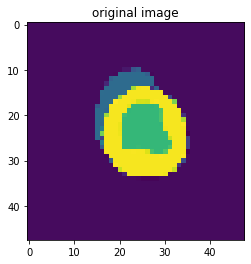

In [9]:
plt.imshow(image)
plt.title('original image')

## 1 Validation of derivative

1. show that tensor auto-grad is working;
2. show that the tensor gradient is close to numeric derivative.

Notice, tfNufftObj.test_derivative(x) is using dense matrix but not tf.sparse.SparseTensor. 

In [10]:
tfNufftObj = tfNUFFT()
tfNufftObj.plan(om, Nd, Kd, Jd, batch_image.shape[0]) #
tfNufftObj.preapre_for_tf() #convert array to tensor

In [11]:
b = np.random.rand(len(om),batch)+1j*np.random.rand(len(om),batch)
b = tf.cast(b, tfNufftObj.dtype)

Auto-grad using tensor.

In [12]:
x = tf.cast(batch_image, tf.float32)
with tf.GradientTape() as t:
    t.watch(x)
    y = tf.reduce_sum(abs((tfNufftObj.test_derivative(x)-b)**2))
    
tf_dx = t.gradient(y, x) #Auto-grad using tensor.

Numerically approximate the derivative: numeric_dx = (f(x+d) - f(x-d))/(2d).

And here I use `dif` the sum up the relative residual error of auto-grad and numeric derivative.

Relative residual error is calculated as abs(numeric_dx-tf_dx)/abs(tf_dx).

In [13]:
indices = [[None for _ in range(len(batch_image.shape))] for _ in range(Nd[0]*Nd[1])]
grid = np.meshgrid(batch-1,range(0,Nd[0]),range(0,Nd[1])) #indices for the whole image
m = 0
for i,j,k in zip(grid[0].ravel(),grid[1].ravel(),grid[2].ravel()):
    indices[m] = [i,j,k]
    m += 1
    
randomind = np.random.choice(len(indices),100,replace=False) #randomly select 100 points for validation

In [14]:
d = 1e-1
x = batch_image.copy()
numeric_dx = np.zeros_like(x)
dif = 0 # abs dif between tf auto grad and numeric

for ind in randomind:
    i,j,k = indices[ind]
    n = np.zeros_like(x)
    n[i][j][k] = 1

    y1 = tf.reduce_sum(abs((tfNufftObj.forward(x-n*d)-b)**2))
    y2 = tf.reduce_sum(abs((tfNufftObj.forward(x+n*d)-b)**2))
    numeric_dx[i][j][k] = (y2-y1)/2/d
    dif += abs(numeric_dx[i][j][k]-tf_dx[i][j][k])/abs(tf_dx[i][j][k])

In [15]:
print('The total relative error between auto-grad and numeric of 100 point is: %.3f'%dif)

The total relative error between auto-grad and numeric of 100 point is: 0.327


## 2 Validation of Nufft

In [16]:
batch_image.shape

(1, 48, 48)

In [17]:
FOV_x = 0.24
FOV_y = 0.24
[Nx,Ny] = Nd

dx = FOV_x/Nx;
dy = FOV_y/Ny;

def systemMatrix(trajectory):
    Ns = len(trajectory)
    [xq,yq] = np.meshgrid(np.linspace(-Nx//2+1, Nx//2, Nx)*dx,
                          np.linspace(-Ny//2+1, Ny//2, Ny)*dy)
    grid = np.concatenate([np.reshape(xq,(-1,1)), np.reshape(yq,(-1,1))], axis=1)
    operator = np.matmul(trajectory, grid.T)
    F = 1/np.sqrt(Ns)*np.exp(-1j*operator)
    E = F.reshape(Ns, Nx*Ny)
    return E

def genNonUniK(E, data):
    data = data.reshape((-1,1))
    E = E.dot(data)
    return tf.cast(E, tf.complex64)

Notice that here Nufft_k is normalized by multiplying 1/np.sqrt(n).

Because the forward FFT does not perform normalization and normalization is done in the inverse transform by scaling it to 1/n.

In [18]:
E = systemMatrix(traj)
E_k = genNonUniK(E, batch_image) #generate non-uniform kspace data from system matrix

Nufft_k = 1/Nd[0]*tfNufftObj.forward(batch_image) # non-uniform ksp from Nufft

In [19]:
print(len(E_k))

4783


/opt/anaconda3/envs/dl/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[(0, 1000), Text(0.5, 1.0, 'E_k - Nufft_k zoomed in'), None]

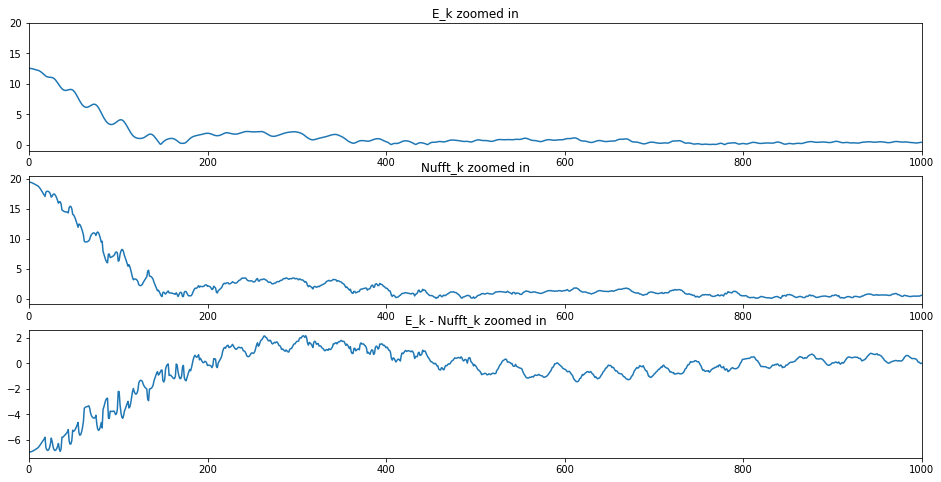

In [20]:
dif = (E_k - Nufft_k)

fig,ax = plt.subplots(3,1,figsize=(16,8))
ax[0].plot(abs(E_k))
ax[0].set(xlim=(0,1000),ylim = (-1,20),autoscale_on=True,
           title='E_k zoomed in')

ax[1].plot(abs(Nufft_k))
ax[1].set(xlim=(0,1000), autoscale_on=True,
           title='Nufft_k zoomed in')

ax[2].plot(dif)
ax[2].set(xlim=(0,1000),autoscale_on=True,
           title='E_k - Nufft_k zoomed in')

[(0, 500), Text(0.5, 1.0, 'E_k - Nufft_k (real part) zoomed in'), None]

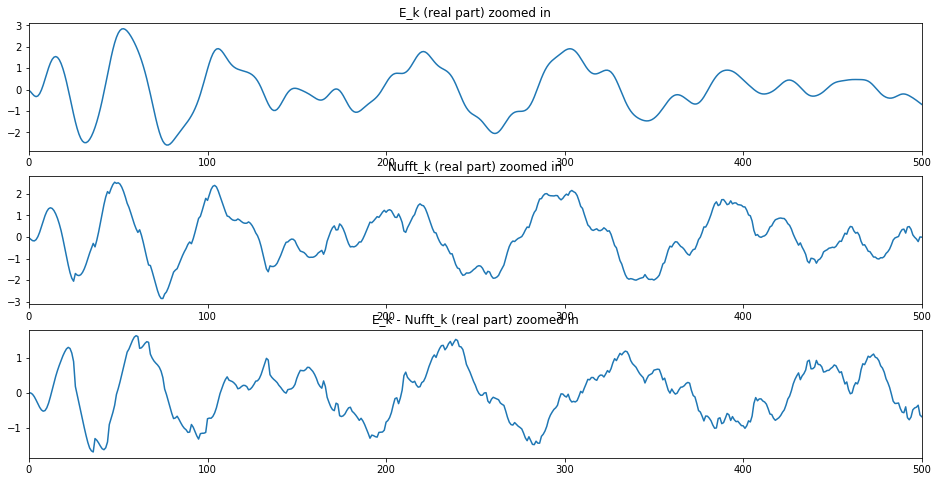

In [21]:
E_angle = tf.math.imag(E_k)
Nufft_angle = tf.math.imag(Nufft_k)
dif = E_angle-Nufft_angle

fig,ax = plt.subplots(3,1,figsize=(16,8))
ax[0].plot(E_angle)
ax[0].set(xlim=(0,500), autoscale_on=True,
           title='E_k (real part) zoomed in')

ax[1].plot(Nufft_angle )
ax[1].set(xlim=(0,500),autoscale_on=True,
           title='Nufft_k (real part) zoomed in')

ax[2].plot(dif)
ax[2].set(xlim=(0,500),autoscale_on=True,
           title='E_k - Nufft_k (real part) zoomed in')

[(0, 500), Text(0.5, 1.0, 'E_k - Nufft_k (imaginary part) zoomed in'), None]

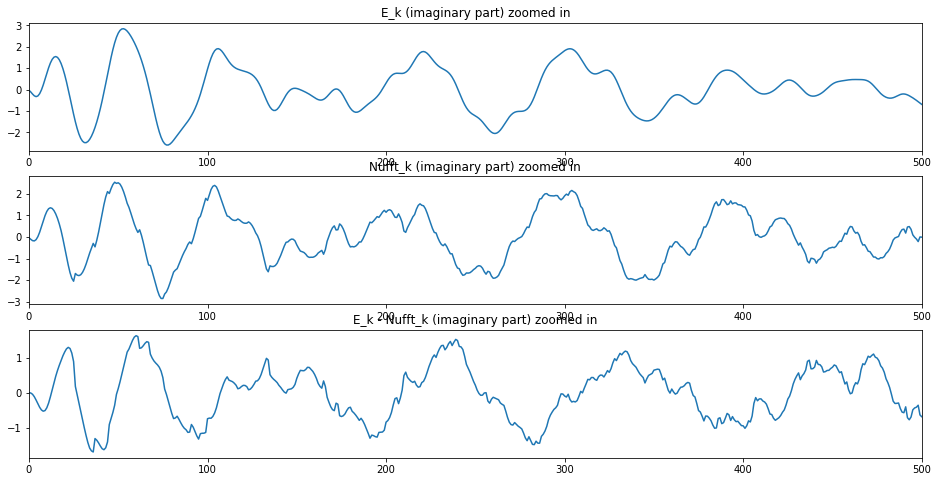

In [22]:
E_angle = tf.math.imag(E_k)
Nufft_angle = tf.math.imag(Nufft_k)
dif = E_angle-Nufft_angle

fig,ax = plt.subplots(3,1,figsize=(16,8))
ax[0].plot(E_angle)
ax[0].set(xlim=(0,500), autoscale_on=True,
           title='E_k (imaginary part) zoomed in')

ax[1].plot(Nufft_angle )
ax[1].set(xlim=(0,500),autoscale_on=True,
           title='Nufft_k (imaginary part) zoomed in')

ax[2].plot(dif)
ax[2].set(xlim=(0,500),autoscale_on=True,
           title='E_k - Nufft_k (imaginary part) zoomed in')

Also, we can test if the Nufft operator calculated from Nufft_ksp works on E_k.

In [23]:
tfNufftObj = tfNUFFT()
tfNufftObj.plan(om, Nd, Kd, Jd, batch)
tfNufftObj.preapre_for_tf()
Nufft_k = tfNufftObj.forward(batch_image)
Nufft_adj = tfNufftObj.adjoint(Nufft_k)

# as mentioned above, tf.signal.fft does not perform normalization. 
# Correspondingly we need to scale E_k to sqrt(n) before use E_k as input for adjoint
E_k2 = E_k * Nd[0]
E_adj = tfNufftObj.adjoint(E_k2)

Text(0.5, 1.0, 'adj image from Nufft_k')

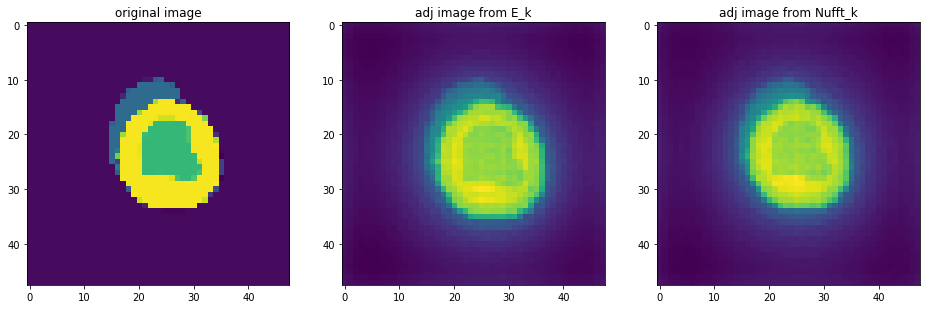

In [24]:
fig,ax = plt.subplots(1,3,figsize=(16,8))

ax[0].imshow(batch_image[0])
ax[0].set_title('original image')
ax[1].imshow(abs(E_adj[0]))
ax[1].set_title('adj image from E_k')
ax[2].imshow(abs(Nufft_adj[0]))
ax[2].set_title('adj image from Nufft_k')

## 3 Validation of batches


Here I repeat the same 2D image for batch times.

In [25]:
batch = 4
batch_image = np.expand_dims(image, axis=0)
batch_image = np.tile(batch_image, [batch,1,1])

In [26]:
print(batch_image.shape)

(4, 48, 48)


In [27]:
tfNufftObj = tfNUFFT()
tfNufftObj.plan(om, Nd, Kd, Jd, batch)
tfNufftObj.preapre_for_tf()
kspace = tfNufftObj.forward(batch_image)
Nufft_adj = tfNufftObj.adjoint(kspace)

In [28]:
print(Nufft_adj.shape)

(4, 48, 48)


To validate that the batch works, I try to show that the adjoint image at every slice is the same.

In [29]:
for i in range(1,batch):
    print(np.sum(Nufft_adj[0]-Nufft_adj[i]))

0j
0j
0j


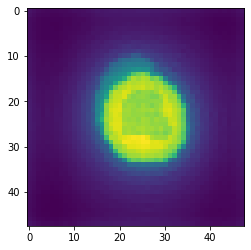

In [30]:
plt.imshow(abs(Nufft_adj[0]))

Validation using 3D images.


In [31]:
DATA_PATH = './data/'
image = np.load(DATA_PATH + 'phantom_3D_128_128_128.npz')['arr_0']

image = cv2.resize(image,(48,48))
image = image[:,:,::4]

traj = np.load(os.path.join(DATA_PATH, '3dspiral.npy'))
new_traj = np.zeros_like(traj)
new_traj[:,0] = traj[:,1]
new_traj[:,1] = traj[:,0]
new_traj[:,2] = traj[:,2]
om = new_traj
om = om / om.max() * 3  # normalized between (-pi,pi)


In [32]:
Nd = image.shape # image size
Kd = Nd # fft size
Jd = (3,3,3) #kernel size

In [33]:
batch = 4
batch_image = np.expand_dims(image, axis=0)
batch_image = np.tile(batch_image, [batch,1,1,1])

tfNufftObj = tfNUFFT()
tfNufftObj.plan(om, Nd, Kd, Jd, batch)
tfNufftObj.preapre_for_tf()
kspace = tfNufftObj.forward(batch_image)
Nufft_adj = tfNufftObj.adjoint(kspace)

In [34]:
print(batch_image.shape)

(4, 48, 48, 32)


In [35]:
for i in range(1,batch):
    print(np.sum(Nufft_adj[0]-Nufft_adj[i]))

0j
0j
0j


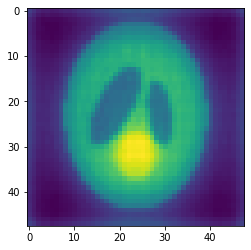

In [36]:
plt.imshow(abs(Nufft_adj[0,:,:,16]))